In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 绘图参数
params = {'font.family'    : 'serif',  # 衬线字体族
          'font.serif'     : 'Times New Roman',
          'legend.fontsize': 20,
          # 'figure.dpi'     : 100,
          'savefig.dpi'    : 600,
        #   'figure.figsize' : (15, 5),
          'axes.labelsize' : 20,
          'axes.titlesize' : 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          }
plt.rcParams.update(params)

In [3]:
# 路径下的所有txt文件
file = [i for i in os.listdir('.') if i.endswith('.txt')]

In [4]:
file

['1-CV 1 M KOH 20cycles(0.1~0.6V) NiCo2O4.txt',
 '2.3-LSV 1 M KOH OER OCP-0.1975 iR-95%-1.3Ω (0~0.8V) NiCo2O4.txt',
 '3-EIS 0.6357V-NiCo2O4.txt',
 '4.1-Cdl-10 mV s-1.txt',
 '4.2-Cdl-20 mV s-1.txt',
 '4.3-Cdl-40 mV s-1.txt',
 '4.4-Cdl-60 mV s-1.txt',
 '4.5-Cdl-80 mV s-1.txt',
 '4.6-Cdl-100 mV s-1.txt']

In [5]:
keywords = ['CV', 'LSV', 'EIS', 'Cdl']

In [6]:
cv  = list(filter(lambda text: all([keyword in text for keyword in [keywords[0]]]), file ))
lsv = list(filter(lambda text: all([keyword in text for keyword in [keywords[1]]]), file ))
eis = list(filter(lambda text: all([keyword in text for keyword in [keywords[2]]]), file ))
cdl = list(filter(lambda text: all([keyword in text for keyword in [keywords[3]]]), file ))

In [7]:
cv, lsv, eis, cdl

(['1-CV 1 M KOH 20cycles(0.1~0.6V) NiCo2O4.txt'],
 ['2.3-LSV 1 M KOH OER OCP-0.1975 iR-95%-1.3Ω (0~0.8V) NiCo2O4.txt'],
 ['3-EIS 0.6357V-NiCo2O4.txt'],
 ['4.1-Cdl-10 mV s-1.txt',
  '4.2-Cdl-20 mV s-1.txt',
  '4.3-Cdl-40 mV s-1.txt',
  '4.4-Cdl-60 mV s-1.txt',
  '4.5-Cdl-80 mV s-1.txt',
  '4.6-Cdl-100 mV s-1.txt'])

In [11]:
cv_data1 = pd.read_table(cv[0], index_col=None, header=None, skiprows=0, sep=',')

In [15]:
cv_data1.head(100)

,0,1
0,Sept. 7,2022 15:35:46
1,Cyclic Voltammetry,NaN
2,File: f:\2-Data Source: Experiment,NaN
3,Instrument Model: CHI760E,NaN
4,Header:,NaN
...,...,...
95,0.139,-3.681e-3
96,0.140,-3.672e-3
97,0.141,-3.662e-3
98,0.142,-3.652e-3


In [38]:
scan_rate = cv_data1[cv_data1.iloc[:,0].str.contains("Scan Rate")].iloc[0,0].split(sep=' ')[-1]
low_E = cv_data1[cv_data1.iloc[:,0].str.contains("Low E")].iloc[0,0].split(sep=' ')[-1]
high_E = cv_data1[cv_data1.iloc[:,0].str.contains("High E")].iloc[0,0].split(sep=' ')[-1]

In [318]:
# 读取原始数据
cv_data = pd.read_table(cv[0], skiprows=97, sep=',')
lsv_data = pd.read_table(lsv[0], skiprows=16, sep=',')
eis_data = pd.read_table(eis[0], skiprows=15, sep=',')

In [319]:
shift = 0.9181  # 电极转换电势
area = 2        # 工作电极表面积

In [320]:
# 转换不同扫速CV的数据用于Cdl计算
def ref_to_RHE(cdl):
    cdl_data = pd.read_table(cdl, skiprows=37, sep=',')
    cdl_data_RHE = pd.concat([cdl_data.iloc[:,0]+shift, cdl_data.iloc[:,1]*1000/area], axis=1)
    
    return(cdl_data_RHE)

In [321]:
# 将原始数据转换为相对RHE的数据
cv_data_RHE  = pd.concat([cv_data, cv_data.iloc[:,0]+shift, cv_data.iloc[:,1]*1000/area], axis=1)
lsv_data_RHE = pd.concat([lsv_data, 
                          lsv_data.iloc[:,0]+shift, lsv_data.iloc[:,1]*1000/area, 
                          np.log(np.abs(lsv_data.iloc[:,1]*1000/area)), lsv_data.iloc[:,0]+shift-1.23], axis=1)
cdl_data_RHE = pd.concat([ref_to_RHE(i) for i in cdl], axis = 1)

In [322]:
# 整理Cdl数据用于绘图
cdl_data_RHE_x = cdl_data_RHE.iloc[:,0]  # 电压值
cdl_data_RHE_y = cdl_data_RHE.iloc[:, [i%2==1 for i in range(len(cdl_data_RHE.columns))]]  # 电流值

# 电流密度差数据
scan_rate = [10, 20, 40, 60, 80, 100]
ja = cdl_data_RHE_y.iloc[850,:]
jc = cdl_data_RHE_y.iloc[950,:]
j_diff = (ja-jc)/2*1000/2

# 线性拟合
fit = np.polyfit(scan_rate, j_diff, 1)
y_fit = np.poly1d(fit)
y_fit_data = y_fit(scan_rate)

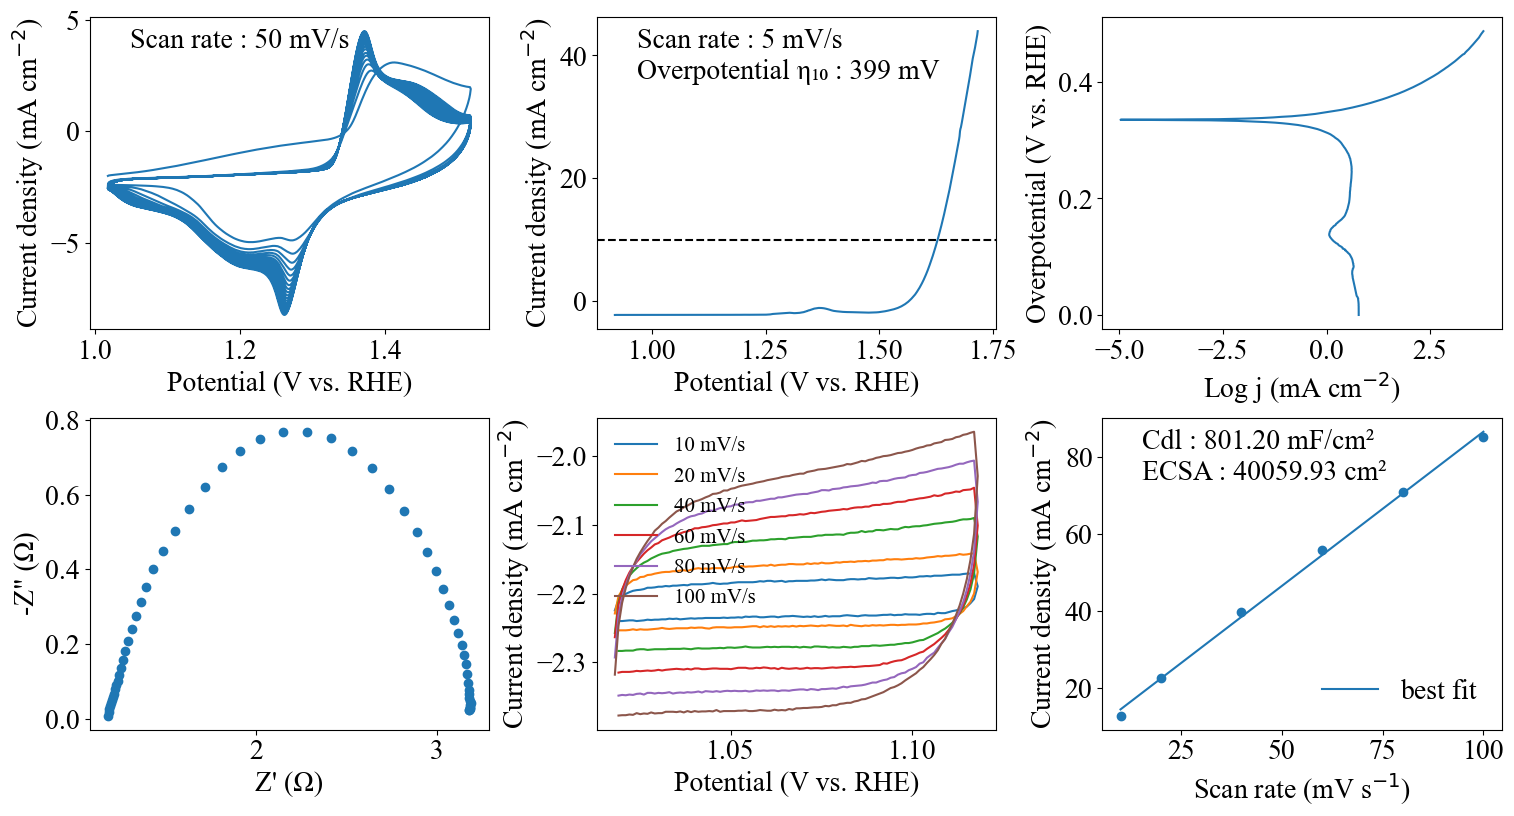

: 

In [323]:
# 绘制电化学数据图
fig, axs = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=True)

# CV
axs[0,0].plot(cv_data_RHE.iloc[:,2], cv_data_RHE.iloc[:,3])
axs[0,0].set_xlabel("Potential (V vs. RHE)")
axs[0,0].set_ylabel("Current density (mA cm$^{-2}$)")
axs[0,0].annotate("Scan rate : 50 mV/s".format(fit[0]*1000), xy=(.1, .9), xycoords='axes fraction', fontsize=20)

# LSV
axs[0,1].plot(lsv_data_RHE.iloc[:,2], lsv_data_RHE.iloc[:,3])
axs[0,1].axhline(y=10, c='k', ls='--')
axs[0,1].set_xlabel("Potential (V vs. RHE)")
axs[0,1].set_ylabel("Current density (mA cm$^{-2}$)")
closest_10_index = (lsv_data_RHE.iloc[:,3]-10).abs().argsort()[0]    # 电流密度最接近10的行索引
overpotential = (lsv_data_RHE.iloc[closest_10_index,2] - 1.23)*1000  # 过电位
axs[0,1].annotate("Scan rate : 5 mV/s".format(fit[0]*1000), xy=(.1, .9), xycoords='axes fraction', fontsize=20)
axs[0,1].annotate("Overpotential η₁₀ : {:.0f} mV".format(overpotential), xy=(.1, .8), xycoords='axes fraction', fontsize=20)

# Tafel
tafel_data = lsv_data_RHE.iloc[:,[4, 5]]
tafel_data_new = tafel_data[(tafel_data.iloc[:,1] > 0)]  # 删除Tafel曲线中y坐标小于零的部分
axs[0,2].plot(tafel_data_new.iloc[:,0], tafel_data_new.iloc[:,1])
axs[0,2].set_xlabel("Log j (mA cm$^{-2}$)")
axs[0,2].set_ylabel("Overpotential (V vs. RHE)")

# EIS
eis_data_new = eis_data[(eis_data.iloc[:,2] < 0)]  # 删除Tafel曲线中y坐标小于零的部分
axs[1,0].scatter(eis_data_new.iloc[:,1], -eis_data_new.iloc[:,2])
axs[1,0].set_xlabel("Z' (Ω)")
axs[1,0].set_ylabel('-Z" (Ω)')

# CV curves with different scan rates
for i, j in zip(range(cdl_data_RHE_y.shape[1]), scan_rate):
    axs[1,1].plot(cdl_data_RHE_x[-200:], cdl_data_RHE_y.iloc[-200:,i], label="{} mV/s".format(j))
axs[1,1].legend(fontsize=15, frameon=False)
axs[1,1].set_xlabel("Potential (V vs. RHE)")
axs[1,1].set_ylabel("Current density (mA cm$^{-2}$)")

# Cdl and ECSA
axs[1,2].scatter(scan_rate, j_diff)
axs[1,2].plot(scan_rate, y_fit_data, label="best fit")
axs[1,2].set_xlabel("Scan rate (mV s$^{-1}$)")
axs[1,2].set_ylabel("Current density (mA cm$^{-2}$)")
axs[1,2].legend(fontsize=20, frameon=False, loc='lower right')
axs[1,2].annotate("Cdl : {:.2f} mF/cm²".format(fit[0]*1000), xy=(.1, .9), xycoords='axes fraction', fontsize=20)
axs[1,2].annotate("ECSA : {:.2f} cm²".format(fit[0]*1000/0.04*area), xy=(.1, .8), xycoords='axes fraction', fontsize=20)

plt.savefig('results.png', facecolor ="w")
plt.show()